In [1]:
import rasterio as rio
import rasterio
import rasterio.mask
from rasterio.plot import plotting_extent
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import os
import seaborn as sns
import fiona

In [58]:
year = 2018

In [59]:
with fiona.open("../ethiopia_shapefiles/gadm36_ETH_3.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

In [60]:
with rasterio.open(f"tiffs/eth_predictions_{year}.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
    out_meta = src.meta.copy()

In [61]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [62]:
# raw tiff from EE
preds = rio.open('tiffs/eth_predictions_2015-2.tif')

# masked to Ethiopia shape
preds = rio.open('RGB.byte.masked.tif')

In [63]:
preds.bounds

BoundingBox(left=32.98613723286883, bottom=3.3956317739717914, right=47.97003617198244, top=14.849151646495692)

In [64]:
preds.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 556,
 'height': 425,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.026949458523585646, 0.0, 32.98613723286883,
        0.0, -0.026949458523585646, 14.849151646495692)}

In [65]:
preds.count

1

In [66]:
cmap = plt.cm.Blues
cmap.set_bad(color='black')

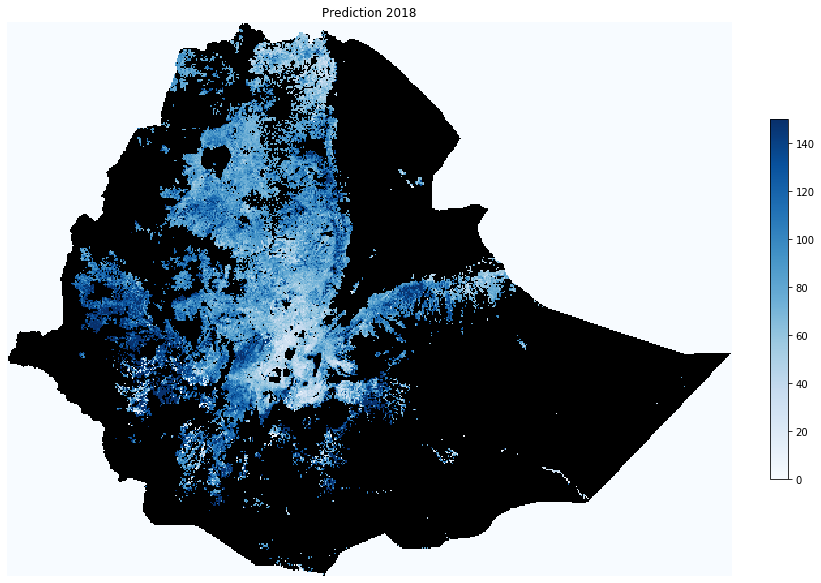

In [67]:
p = preds.read(1, masked=True) # Read the appropriate band
fig, ax = plt.subplots(figsize = (14,20))
chm_plot = ax.imshow(p, 
                     cmap=cmap,
                     vmin=0,
                     vmax=150)
fig.colorbar(chm_plot, fraction=.023, ax=ax)
ax.set_title(f"Prediction {year}")
ax.set_axis_off();

In [68]:
fig.savefig(f"prediction_maps/{year}.png", dpi=180)